In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("../PreProcessingResumes/processed_data/Resume_removeStopword_useLemm/train.csv")
df.head()

,ID,Resume_str,Category
0,28111403,president chief executive officer executive pr...,INFORMATION-TECHNOLOGY
1,29908929,business development marketing summary busines...,BUSINESS-DEVELOPMENT
2,15261348,chef restaurant manager summary chef year high...,CHEF
3,75435017,charge nurse professional summary objective ob...,HEALTHCARE
4,41152404,test analyst intern contractor profile year pr...,INFORMATION-TECHNOLOGY


In [3]:
# TF-IDF vectorizer that converts a collection of raw text documents into a matrix of TF-IDF features
tfidf_vect = TfidfVectorizer(
    lowercase=True,         # Convert all text to lowercase
    binary=False,           # Use term frequency, not just presence/absence
    max_features=10000,     # Keep only the top 10,000 most frequent terms
    ngram_range=(1, 3),     # Extract n-grams
    max_df=0.8,             # Ignore terms that appear in more than 80% of documents
    min_df=2                # Ignore terms that appear in fewer than 2 documents
)

### Support Vector Classifier

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
class_counts = df['Category'].value_counts()
min_classes = class_counts[class_counts < 0.75*class_counts.mean()].index.tolist()

print(f"Applying SMOTE to classes: {min_classes}")

target_size = int(0.75*class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

Applying SMOTE to classes: ['ADVOCATE', 'APPAREL', 'BPO', 'AGRICULTURE', 'ARTS', 'AUTOMOBILE']


In [6]:
pipeline = Pipeline([
    ('tfidf', tfidf_vect),
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=4)),
    ('clf', SVC(probability=True, random_state=42))
])

In [7]:
param_grid = [
    {
        'clf__kernel': ['linear'],
        'clf__C': [0.2, 0.4]
    },
    {
        'clf__kernel': ['poly'],
        'clf__C': [0.1],
        'clf__degree': [2],
        'clf__coef0': [1.0, 1.2]
    }
]


scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted']

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring= scoring,
    refit = False,
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(df['Resume_str'], df['Category'])

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")

GridSearchCV took 460.87 seconds for 4 candidates parameter settings.



In [8]:
# Convert the cross-validation results from GridSearchCV into a pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Sort the results by the weighted F1 score in descending order
results_df = results_df.sort_values(by='mean_test_f1_weighted', ascending=False).reset_index(drop=True)

In [9]:
for i in range(len(results_df)):
    print(f"\n[{i+1}] Params: {results_df['params'][i]}")
    
    for metric in scoring:
        
        print(f"{metric.upper()}:")
        print(f"\tTRAIN:", end='')
        for fold in range(skf.get_n_splits()):
            print(f"\tFold {fold+1}: {results_df[f'split{fold}_train_{metric}'][i]:.4f}", end='')
        print(f"\t\tMean: {results_df[f'mean_train_{metric}'][i]:.4f}", end='')
        print(f"\tStd: {results_df[f'std_train_{metric}'][i]:.4f}")

        print(f"\tTEST:", end='')
        for fold in range(skf.get_n_splits()):
            print(f"\tFold {fold+1}: {results_df[f'split{fold}_test_{metric}'][i]:.4f}", end='')
        print(f"\t\tMean: {results_df[f'mean_test_{metric}'][i]:.4f}", end='')
        print(f"\tStd: {results_df[f'std_test_{metric}'][i]:.4f}\n")


[1] Params: {'clf__C': 0.4, 'clf__kernel': 'linear'}
ACCURACY:
	TRAIN:	Fold 1: 0.8602	Fold 2: 0.8678	Fold 3: 0.8735	Fold 4: 0.8578	Fold 5: 0.8641		Mean: 0.8647	Std: 0.0056
	TEST:	Fold 1: 0.6960	Fold 2: 0.6826	Fold 3: 0.6398	Fold 4: 0.6574	Fold 5: 0.6423		Mean: 0.6636	Std: 0.0222

F1_WEIGHTED:
	TRAIN:	Fold 1: 0.8599	Fold 2: 0.8671	Fold 3: 0.8723	Fold 4: 0.8579	Fold 5: 0.8624		Mean: 0.8639	Std: 0.0052
	TEST:	Fold 1: 0.6941	Fold 2: 0.6813	Fold 3: 0.6430	Fold 4: 0.6501	Fold 5: 0.6353		Mean: 0.6608	Std: 0.0228

PRECISION_WEIGHTED:
	TRAIN:	Fold 1: 0.8765	Fold 2: 0.8804	Fold 3: 0.8888	Fold 4: 0.8750	Fold 5: 0.8773		Mean: 0.8796	Std: 0.0049
	TEST:	Fold 1: 0.7288	Fold 2: 0.7276	Fold 3: 0.6933	Fold 4: 0.6704	Fold 5: 0.6743		Mean: 0.6989	Std: 0.0252

RECALL_WEIGHTED:
	TRAIN:	Fold 1: 0.8602	Fold 2: 0.8678	Fold 3: 0.8735	Fold 4: 0.8578	Fold 5: 0.8641		Mean: 0.8647	Std: 0.0056
	TEST:	Fold 1: 0.6960	Fold 2: 0.6826	Fold 3: 0.6398	Fold 4: 0.6574	Fold 5: 0.6423		Mean: 0.6636	Std: 0.0222

ROC_AUC_OVR_WE

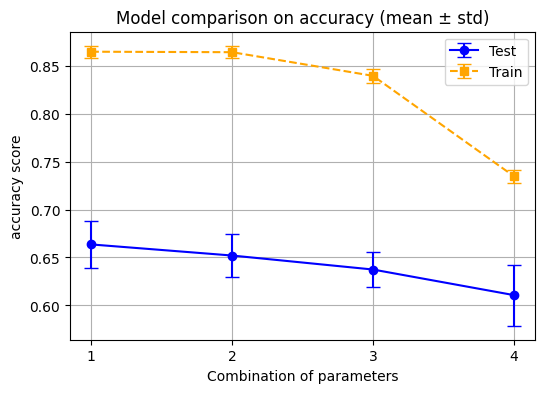

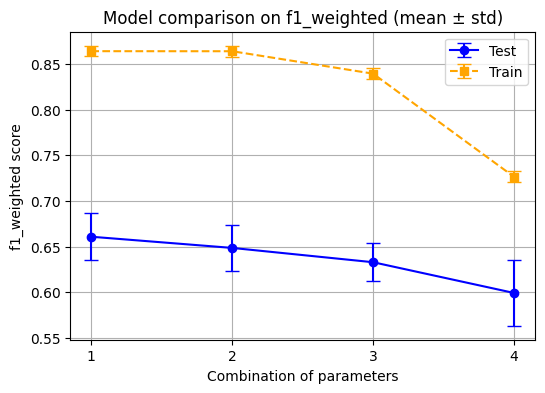

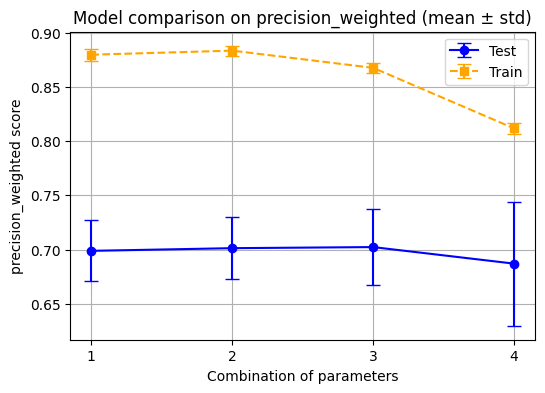

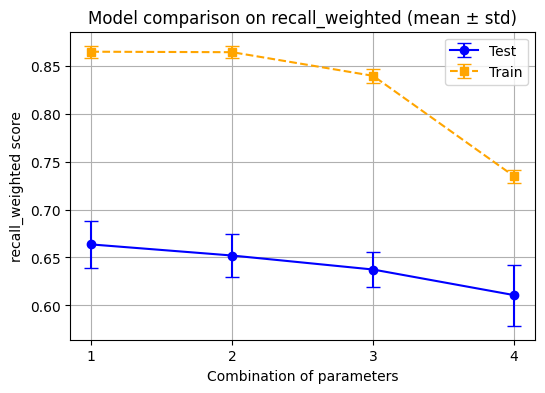

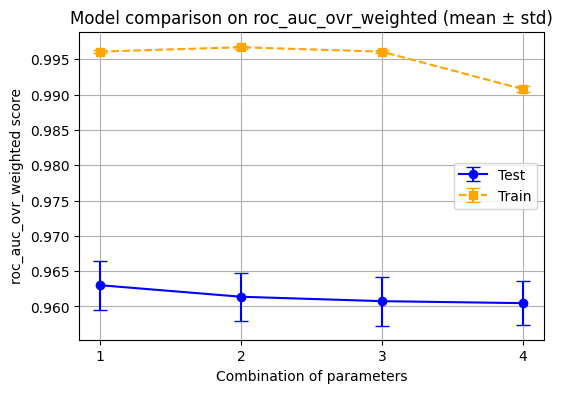

In [10]:
for metric in scoring:
    data_test = {}
    data_train = {}
    for i in range(len(results_df)):
        col_name = f'{i+1}'
        data_test[col_name] = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]
        data_train[col_name] = [results_df[f'split{fold}_train_{metric}'][i] for fold in range(skf.get_n_splits())]

    df_test = pd.DataFrame(data_test)
    df_train = pd.DataFrame(data_train)

    means_test = df_test.mean()
    stds_test = df_test.std()
    means_train = df_train.mean()
    stds_train = df_train.std()

    plt.figure(figsize=(max(6, len(results_df) * 0.75), 4))

    plt.errorbar(means_test.index, means_test.values, yerr=stds_test.values, fmt='-o', capsize=5, label='Test', color='blue')

    plt.errorbar(means_train.index, means_train.values, yerr=stds_train.values, fmt='--s', capsize=5, label='Train', color='orange')

    plt.ylabel(f'{metric} score')
    plt.xlabel('Combination of parameters')
    plt.title(f'Model comparison on {metric} (mean ± std)')
    plt.legend()
    plt.grid(True)
    plt.show()

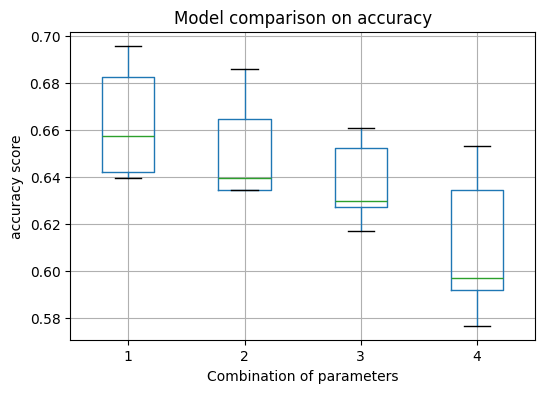

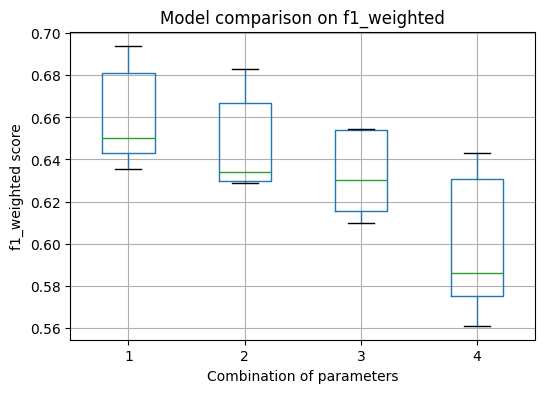

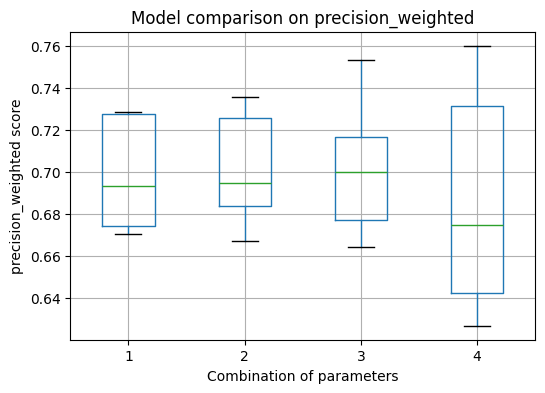

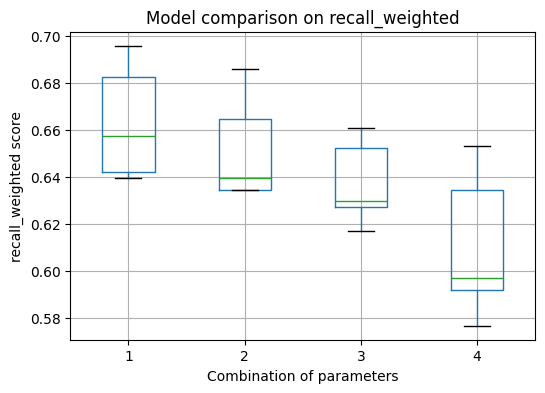

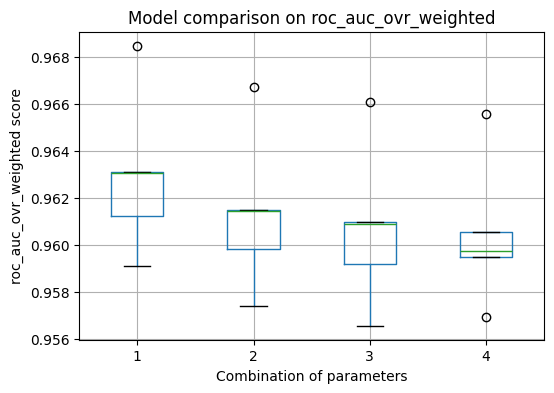

In [11]:
for metric in scoring:
    data = {}
    for i in range(len(results_df)):
        col_name = f'{i+1}'
        data[col_name] = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]

    df_metric = pd.DataFrame(data)
    ax = df_metric.boxplot(figsize=(max(6, len(results_df) * 0.75), 4))
    ax.set_ylabel(f'{metric} score')
    ax.set_xlabel('Combination of parameters')
    plt.title(f'Model comparison on {metric}')
    plt.grid(True)
    plt.show()

In [12]:
output_file = "compare/results.json"
section_key = "TFIDF"

# Only process the first row
i = 0
entry = {
    "params": results_df['params'][i],
    "metrics": {}
}

for metric in scoring:
    train_folds = [results_df[f'split{fold}_train_{metric}'][i] for fold in range(skf.get_n_splits())]
    test_folds = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]

    entry["metrics"][metric] = {
        "train": {
            "folds": train_folds,
            "mean": results_df[f'mean_train_{metric}'][i],
            "std": results_df[f'std_train_{metric}'][i]
        },
        "test": {
            "folds": test_folds,
            "mean": results_df[f'mean_test_{metric}'][i],
            "std": results_df[f'std_test_{metric}'][i]
        }
    }

# Load or initialize the JSON structure
if os.path.exists(output_file):
    with open(output_file, 'r') as f:
        data = json.load(f)
else:
    data = {}

data[section_key] = entry

# Write the full updated JSON back to file
with open(output_file, 'w') as f:
    json.dump(data, f, indent=4)

print(f"Saved the best model")

Saved the best model
